In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https

In [5]:
!pip install BnLemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00


In [6]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [7]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [8]:
df['data'] = df['headline'] + ' ' + df['content']

In [9]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [10]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [11]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
#for column in df.columns:
#    df[column] = df[column].str.slice(0, 100)

In [14]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [15]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0      4575      4
1       756      4
2      1906      4
3      1693      4
4       617      4
...     ...    ...
10387   684      4
10388  1094      4
10389  1981      4
10390   749      4
10391  1211      4

[10392 rows x 2 columns]


In [16]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)


In [17]:
#Stopword Removal
from bnlp import BengaliCorpus as corpus

stop_words = set(corpus.stopwords)


for i in range(0,df.shape[0]):
    words = df['data'][i]
    df['data'][i] =  str([word for word in words if word.lower() not in stop_words])

In [18]:
#Lematizer
import BnLemma as lm
bl = lm.Lemmatizer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = bl.lemma(words)

In [19]:
pip install bangla_stemmer


Note: you may need to restart the kernel to use updated packages.


In [20]:
from bangla_stemmer.stemmer import stemmer

In [21]:
#Stemmer
stemr=stemmer.BanglaStemmer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = stemr.stem(words)

applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied second rules..
applied sec

In [22]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [24]:
pip install ktrain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 53.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 47.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=7964b0a324

In [25]:

import ktrain
from ktrain import text
MODEL_NAME = 'sagorsarker/bangla-bert-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [26]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 2964
	95percentile : 7133
	99percentile : 12344


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 3038
	95percentile : 7449
	99percentile : 12360


In [27]:
model = t.get_classifier()

In [28]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [29]:
history = learner.fit_onecycle(2e-5, 8)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/8
1386/1386 [==============================] - 694s 484ms/step - loss: 0.3224 - accuracy: 0.8914 - val_loss: 0.2641 - val_accuracy: 0.9158
Epoch 2/8
1386/1386 [==============================] - 666s 480ms/step - loss: 0.2490 - accuracy: 0.9165 - val_loss: 0.2560 - val_accuracy: 0.9105
Epoch 3/8
1386/1386 [==============================] - 665s 480ms/step - loss: 0.2421 - accuracy: 0.9172 - val_loss: 0.2872 - val_accuracy: 0.9139
Epoch 4/8
1386/1386 [==============================] - 666s 480ms/step - loss: 0.2331 - accuracy: 0.9218 - val_loss: 0.2969 - val_accuracy: 0.9062
Epoch 5/8
1386/1386 [==============================] - 666s 480ms/step - loss: 0.2132 - accuracy: 0.9282 - val_loss: 0.2495 - val_accuracy: 0.9105
Epoch 6/8
1386/1386 [==============================] - 666s 480ms/step - loss: 0.1794 - accuracy: 0.9362 - val_loss: 0.2697 - val_accuracy: 0.9149
Epoch 7/8
1386/1386 [==============================] - 

In [30]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 47s 667ms/step
              precision    recall  f1-score   support

        fake       0.77      0.57      0.66       261
        true       0.94      0.97      0.96      1818

    accuracy                           0.92      2079
   macro avg       0.85      0.77      0.81      2079
weighted avg       0.92      0.92      0.92      2079



array([[ 150,  111],
       [  46, 1772]])

In [31]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

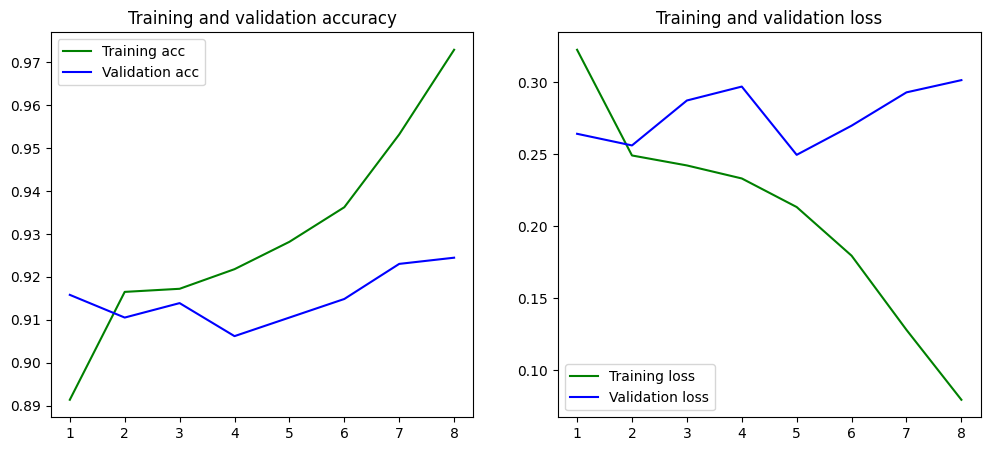

In [32]:
PlotGraph(history)